<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras import layers, models
import random

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [6]:
TARGET_1 = 'btc_logret'

In [7]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [8]:
TARGET_2 = 'btc_logret'

In [9]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Train - Val - Test Split

In [10]:
total_len = len(df)

In [11]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [12]:
train_df.shape

(2629, 29)

In [13]:
val_df.shape

(564, 29)

In [14]:
test_df.shape

(564, 29)

# Scaling

In [15]:
scaler_1 = MinMaxScaler()

In [16]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [17]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1 = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1 = scaler_1.transform(test_df[FEATURES_1])

In [18]:
scaler_2 = MinMaxScaler()

In [19]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [20]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2 = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2 = scaler_2.transform(test_df[FEATURES_2])

# LSTM Sequence Data

In [21]:
def make_sequence_data(values, target, lookback):
  X, y = [], []

  for i in range(lookback, len(values)):
    X.append(values[i - lookback: i])
    y.append(target[i])

  return np.array(X), np.array(y)

In [22]:
LOOKBACK = 60

In [23]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, train_df[TARGET_1].values, LOOKBACK)
X_val_1, y_val_1 = make_sequence_data(val_scaled_1, val_df[TARGET_1].values, LOOKBACK)
X_test_1, y_test_1 = make_sequence_data(test_scaled_1, test_df[TARGET_1].values, LOOKBACK)

X_train_2, y_train_2 = make_sequence_data(train_scaled_2, train_df[TARGET_2].values, LOOKBACK)
X_val_2, y_val_2 = make_sequence_data(val_scaled_2, val_df[TARGET_2].values, LOOKBACK)
X_test_2, y_test_2 = make_sequence_data(test_scaled_2, test_df[TARGET_2].values, LOOKBACK)

## Metrics

In [30]:
def calculate_performance_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  da = np.mean((y_test * y_pred) > 0)

  return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'DA': da}

# Modelling

In [24]:
from itertools import product

In [25]:
GRID = {
    "units": [50, 100],
    "learning_rate": [0.001, 0.005],
    "batch_size": [32, 64],
    "dropout": [0.0, 0.2],
    "patience": [5, 10],
}

grid_combinations = list(product(
    GRID["units"],
    GRID["learning_rate"],
    GRID["batch_size"],
    GRID["dropout"],
    GRID["patience"]
))

In [26]:
len(grid_combinations)

32

In [28]:
def build_lstm(input_shape, units, dropout, learning_rate):
  model = models.Sequential([
      layers.LSTM(units, return_sequences=True, input_shape=input_shape),
      layers.LSTM(units),
      layers.Dropout(dropout),
      layers.Dense(1)
  ])

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
      loss='mse'
  )

  return model

In [29]:
results = []

In [33]:
for i, (units, lr, batch_size, dropout, patience) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"units={units}, lr={lr}, batch={batch_size}, "
        f"dropout={dropout}, patience={patience}")

  # WITHOUT MACRO
  model_1 = build_lstm(X_train_1.shape[1:], units, dropout, lr)

  model_1.fit(
      X_train_1, y_train_1,
      epochs = 50,
      batch_size = batch_size,
      validation_data = (X_val_1, y_val_1),
      callbacks = [
          tf.keras.callbacks.EarlyStopping(patience = patience, restore_best_weights = True)
      ],
      verbose = 0
  )

  y_pred_1 = model_1.predict(X_test_1).ravel()
  metrics_1 = calculate_performance_metrics(y_test_1, y_pred_1)

  # WITH MACRO
  model_2 = build_lstm(X_train_2.shape[1:], units, dropout, lr)

  model_2.fit(
      X_train_2, y_train_2,
      epochs = 50,
      batch_size = batch_size,
      validation_data = (X_val_2, y_val_2),
      callbacks = [
          tf.keras.callbacks.EarlyStopping(patience = patience, restore_best_weights = True)
      ],
      verbose = 0
  )

  y_pred_2 = model_2.predict(X_test_2).ravel()
  metrics_2 = calculate_performance_metrics(y_test_2, y_pred_2)

  results.append({
      "units": units,
      "learning_rate": lr,
      "batch_size": batch_size,
      "dropout": dropout,
      "patience": patience,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] < metrics_1["DA"],
  })



[1/32] units=50, lr=0.001, batch=32, dropout=0.0, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

[2/32] units=50, lr=0.001, batch=32, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[3/32] units=50, lr=0.001, batch=32, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[4/32] units=50, lr=0.001, batch=32, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

[5/32] units=50, lr=0.001, batch=64, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[6/32] units=50, lr=0.001, batch=64, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

[7/32] units=50, lr=0.001, batch=64, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

[8/32] units=50, lr=0.001, batch=64, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

[9/32] units=50, lr=0.005, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

[10/32] units=50, lr=0.005, batch=32, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[11/32] units=50, lr=0.005, batch=32, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step

[12/32] units=50, lr=0.005, batch=32, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

[13/32] units=50, lr=0.005, batch=64, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

[14/32] units=50, lr=0.005, batch=64, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[15/32] units=50, lr=0.005, batch=64, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[16/32] units=50, lr=0.005, batch=64, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[17/32] units=100, lr=0.001, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

[18/32] units=100, lr=0.001, batch=32, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

[19/32] units=100, lr=0.001, batch=32, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

[20/32] units=100, lr=0.001, batch=32, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

[21/32] units=100, lr=0.001, batch=64, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

[22/32] units=100, lr=0.001, batch=64, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

[23/32] units=100, lr=0.001, batch=64, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

[24/32] units=100, lr=0.001, batch=64, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

[25/32] units=100, lr=0.005, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[26/32] units=100, lr=0.005, batch=32, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

[27/32] units=100, lr=0.005, batch=32, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

[28/32] units=100, lr=0.005, batch=32, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

[29/32] units=100, lr=0.005, batch=64, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

[30/32] units=100, lr=0.005, batch=64, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

[31/32] units=100, lr=0.005, batch=64, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

[32/32] units=100, lr=0.005, batch=64, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


## Results

In [59]:
results_df = pd.DataFrame(results)

In [60]:
results_df

,units,learning_rate,batch_size,dropout,patience,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,50,0.001,32,0.0,5,0.000575,0.000875,0.023972,0.029584,0.017245,0.023363,0.488095,0.488095,False,False,False,False
1,50,0.001,32,0.0,10,0.001779,0.001218,0.042177,0.034903,0.036589,0.028860,0.488095,0.486111,True,True,True,True
2,50,0.001,32,0.2,5,0.000803,0.001308,0.028342,0.036173,0.022144,0.030366,0.488095,0.488095,False,False,False,False
3,50,0.001,32,0.2,10,0.000674,0.000560,0.025967,0.023657,0.019556,0.016966,0.488095,0.517857,True,True,True,False
4,50,0.001,64,0.0,5,0.000582,0.000570,0.024126,0.023877,0.017260,0.017219,0.500000,0.505952,True,True,True,False
5,50,0.001,64,0.0,10,0.000585,0.000817,0.024195,0.028580,0.017511,0.021691,0.498016,0.486111,False,False,False,True
6,50,0.001,64,0.2,5,0.000784,0.000653,0.027993,0.025549,0.021722,0.019113,0.488095,0.488095,True,True,True,False
7,50,0.001,64,0.2,10,0.000593,0.001316,0.024344,0.036277,0.017706,0.029580,0.517857,0.488095,False,False,False,True
8,50,0.005,32,0.0,5,0.000662,0.000676,0.025739,0.025995,0.018973,0.019598,0.488095,0.488095,False,False,False,False
9,50,0.005,32,0.0,10,0.001030,0.001208,0.032090,0.034761,0.026282,0.028991,0.488095,0.488095,False,False,False,False


In [61]:
results_df['Macro Better DA'] = ~results_df['Macro Better DA'] # Incorrect '<'

In [62]:
results_df

,units,learning_rate,batch_size,dropout,patience,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,50,0.001,32,0.0,5,0.000575,0.000875,0.023972,0.029584,0.017245,0.023363,0.488095,0.488095,False,False,False,True
1,50,0.001,32,0.0,10,0.001779,0.001218,0.042177,0.034903,0.036589,0.028860,0.488095,0.486111,True,True,True,False
2,50,0.001,32,0.2,5,0.000803,0.001308,0.028342,0.036173,0.022144,0.030366,0.488095,0.488095,False,False,False,True
3,50,0.001,32,0.2,10,0.000674,0.000560,0.025967,0.023657,0.019556,0.016966,0.488095,0.517857,True,True,True,True
4,50,0.001,64,0.0,5,0.000582,0.000570,0.024126,0.023877,0.017260,0.017219,0.500000,0.505952,True,True,True,True
5,50,0.001,64,0.0,10,0.000585,0.000817,0.024195,0.028580,0.017511,0.021691,0.498016,0.486111,False,False,False,False
6,50,0.001,64,0.2,5,0.000784,0.000653,0.027993,0.025549,0.021722,0.019113,0.488095,0.488095,True,True,True,True
7,50,0.001,64,0.2,10,0.000593,0.001316,0.024344,0.036277,0.017706,0.029580,0.517857,0.488095,False,False,False,False
8,50,0.005,32,0.0,5,0.000662,0.000676,0.025739,0.025995,0.018973,0.019598,0.488095,0.488095,False,False,False,True
9,50,0.005,32,0.0,10,0.001030,0.001208,0.032090,0.034761,0.026282,0.028991,0.488095,0.488095,False,False,False,True


In [67]:
results_df.to_csv('lstm_grid_results.csv') # Retraining the model is optional

In [63]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [64]:
best_without_macro

,20
units,100
learning_rate,0.001
batch_size,64
dropout,0.0
patience,5
MSE_1,0.000561
MSE_2,0.002792
RMSE_1,0.023693
RMSE_2,0.052836
MAE_1,0.016993


In [65]:
best_with_macro

,3
units,50
learning_rate,0.001
batch_size,32
dropout,0.2
patience,10
MSE_1,0.000674
MSE_2,0.00056
RMSE_1,0.025967
RMSE_2,0.023657
MAE_1,0.019556


In [75]:
macro_mse_win_rate = results_df["Macro Better MSE"].mean()
macro_mae_win_rate = results_df['Macro Better MAE'].mean()
macro_da_win_rate = results_df["Macro Better DA"].mean()

In [74]:
macro_mse_win_rate

np.float64(0.375)

In [76]:
macro_mae_win_rate

np.float64(0.375)

In [72]:
macro_da_win_rate

np.float64(0.71875)

## Retrain for Plotting

In [81]:
model_1 = models.Sequential([
    layers.LSTM(100, return_sequences=True, input_shape=X_train_1.shape[1:]),
    layers.LSTM(100),
    layers.Dropout(0.0),
    layers.Dense(1)
])

model_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss='mse'
)

In [84]:
history_best_without_macro = model_1.fit(
    X_train_1, y_train_1,
    epochs = 50,
    batch_size = 64,
    validation_data = (X_val_1, y_val_1),
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)
    ],
    verbose = 1
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.0020 - val_loss: 6.0364e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 337ms/step - loss: 0.0017 - val_loss: 6.0600e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 338ms/step - loss: 0.0017 - val_loss: 6.5592e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - loss: 0.0017 - val_loss: 6.8238e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - loss: 0.0017 - val_loss: 6.9619e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.0017 - val_loss: 7.0571e-04


In [87]:
model_2 = models.Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=X_train_2.shape[1:]),
    layers.LSTM(50),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss='mse'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [88]:
history_best_with_macro = model_2.fit(
    X_train_2, y_train_2,
    epochs = 50,
    batch_size = 32,
    validation_data = (X_val_2, y_val_2),
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
    ],
    verbose = 1
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0079 - val_loss: 6.3691e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0019 - val_loss: 8.8113e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0018 - val_loss: 7.4619e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0018 - val_loss: 9.6344e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0018 - val_loss: 8.1134e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0018 - val_loss: 9.4528e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0018 - val_loss: 8.1957e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0017 - val_loss: 7.7784e-04
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0017 - val_loss: 9.4005e-04
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 0.0017 - val_loss: 8.0017e-04
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0017 - val_loss: 8.2436e-04


In [89]:
y_pred_1 = model_1.predict(X_test_1).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


In [90]:
y_pred_2 = model_2.predict(X_test_2).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


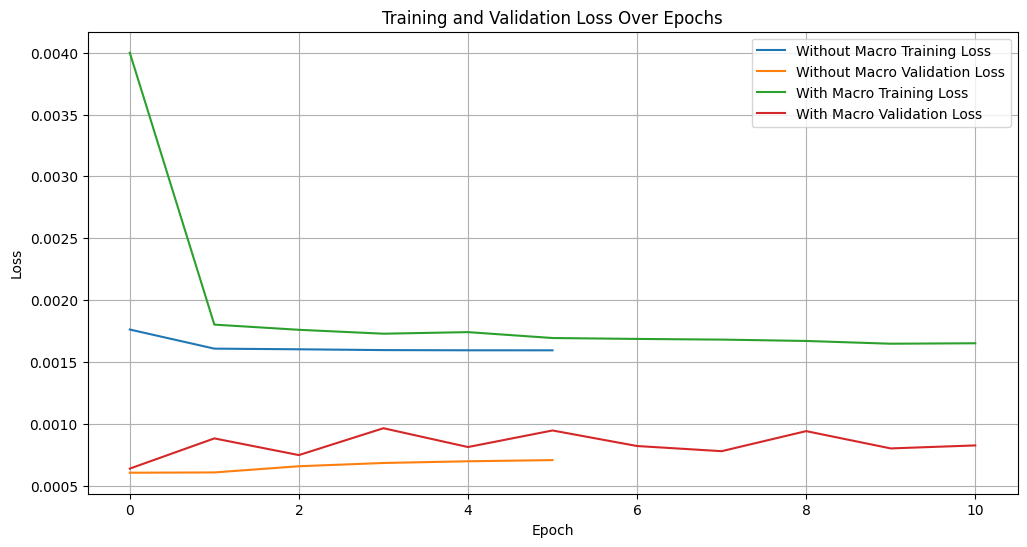

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(history_best_without_macro.history['loss'], label='Without Macro Training Loss')
plt.plot(history_best_without_macro.history['val_loss'], label='Without Macro Validation Loss')
plt.plot(history_best_with_macro.history['loss'], label='With Macro Training Loss')
plt.plot(history_best_with_macro.history['val_loss'], label='With Macro Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

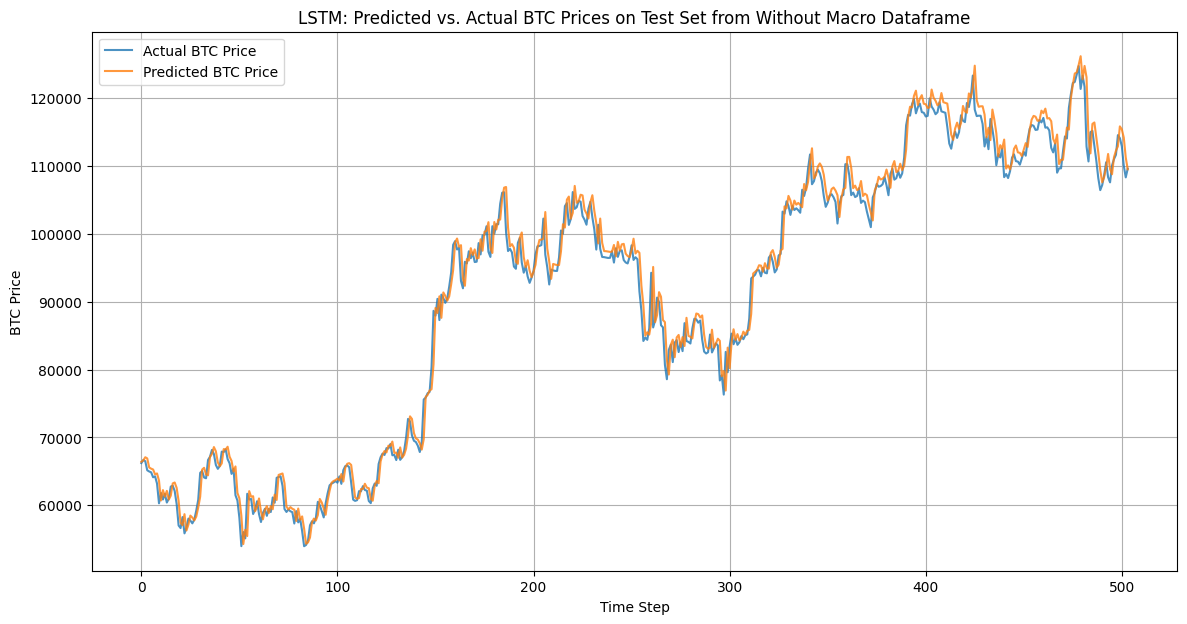

In [92]:
actual_btc_prices = test_df['btc_price'].iloc[LOOKBACK:].values
previous_btc_prices = test_df['btc_price'].iloc[LOOKBACK-1:-1].values
predicted_btc_prices = previous_btc_prices * np.exp(y_pred_1)

plt.figure(figsize=(14, 7))
plt.plot(actual_btc_prices, label='Actual BTC Price', alpha=0.8)
plt.plot(predicted_btc_prices, label='Predicted BTC Price', alpha=0.8)
plt.title('LSTM: Predicted vs. Actual BTC Prices on Test Set from Without Macro Dataframe')
plt.xlabel('Time Step')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.show()

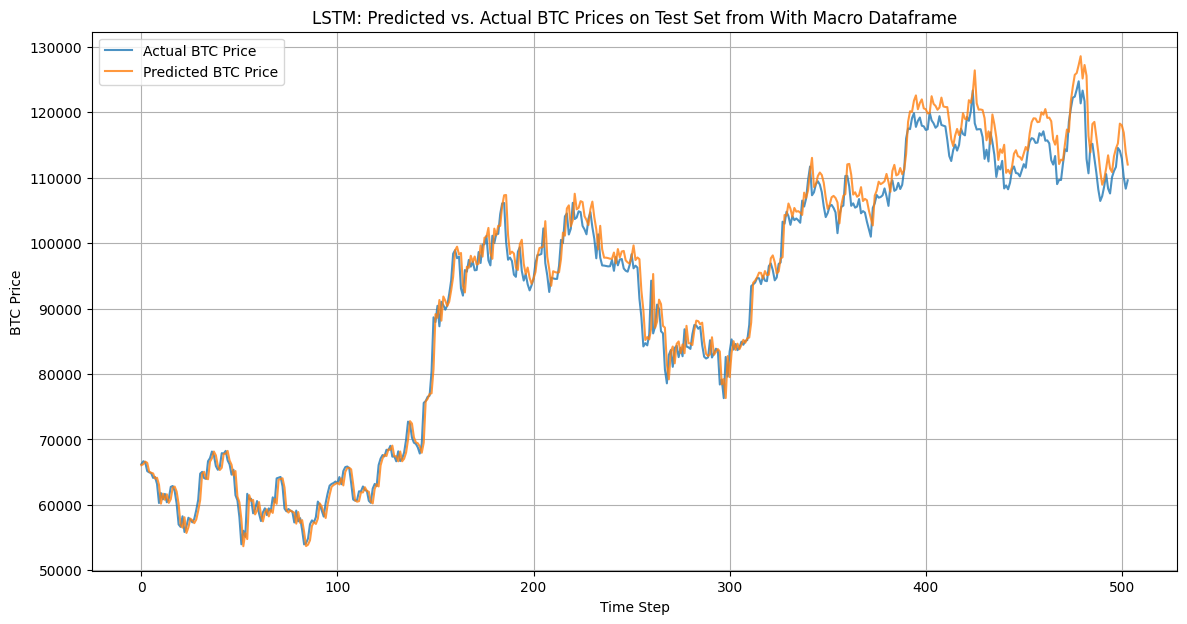

In [93]:
actual_btc_prices = test_df['btc_price'].iloc[LOOKBACK:].values
previous_btc_prices = test_df['btc_price'].iloc[LOOKBACK-1:-1].values
predicted_btc_prices = previous_btc_prices * np.exp(y_pred_2)

plt.figure(figsize=(14, 7))
plt.plot(actual_btc_prices, label='Actual BTC Price', alpha=0.8)
plt.plot(predicted_btc_prices, label='Predicted BTC Price', alpha=0.8)
plt.title('LSTM: Predicted vs. Actual BTC Prices on Test Set from With Macro Dataframe')
plt.xlabel('Time Step')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.show()
